### Prediction of scraped MyAnimeList Data ###

In [55]:
from sklearn import datasets
import numpy as np
import pandas as pd

df = pd.read_csv("anime_df_inclRates - Copy.csv", sep=';')
df.head(10)

,Title,MAL Id,Type,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score
27517,D4 Princess,2723,TV,8 min. per ep.,['Daume'],Manga,"['Action', 'Comedy', 'Sci-Fi']",N\A,PG-13 - Teens 13 or older,8783,6.06
17058,Monoshiri Daigaku: Ashita no Calendar,22221,TV,5 min. per ep.,['add some'],Original,N\A,N\A,G - All Ages,12804,5.69
18703,Wo Jiao Bai Xiaofei,33357,ONA,11 min. per ep.,['Haoliners Animation League'],Web,"['Action', 'Comedy', 'Horror']",N\A,PG-13 - Teens 13 or older,10627,6.15
35052,Tobe! Kujira no Peek,2314,Movie,1 hr. 20 min.,['Urban Product'],Unknown,"['Adventure', 'Drama']",N\A,G - All Ages,11244,6.06
42093,Gon,7867,TV,23 min. per ep.,['Daewon Media'],Manga,"['Action', 'Adventure']",N\A,G - All Ages,9819,5.67
37236,Project HAL,32385,ONA,39 sec. per ep.,['add some'],Original,N\A,N\A,G - All Ages,12603,5.79
20504,Air Recap,36032,Special,22 min.,['Kyoto Animation'],Visual,"['Drama', 'Romance', 'Supernatural']",N\A,PG-13 - Teens 13 or older,6594,6.22
2557,Cyborg 009: The Cyborg Soldier - Yomi no Gunzou,40250,Special,24 min.,['add some'],Manga,"['Action', 'Adventure', 'Sci-Fi']",N\A,PG-13 - Teens 13 or older,13022,6.01
41892,Kick-Flight,40375,ONA,1 min.,['MAPPA'],Game,N\A,"['Game', 'Music']",PG-13 - Teens 13 or older,12869,5.73
1794,21 Emon,5628,TV,25 min. per ep.,['Shin-Ei Animation'],Unknown,"['Comedy', 'Sci-Fi']",N\A,G - All Ages,11857,6.13


delete null information. (if exists)

In [56]:
data_null_total = pd.DataFrame(df.isna().sum()).T.rename({0:'total null'})
data_null_total

,Title,MAL Id,Type,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score
total null,0,0,0,0,0,0,0,0,0,0,0


get info.

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2218 entries, 27517 to 5495
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2218 non-null   object 
 1   MAL Id            2218 non-null   int64  
 2   Type              2218 non-null   object 
 3   Episode Duration  2218 non-null   object 
 4   Studios           2218 non-null   object 
 5   Source Type       2218 non-null   object 
 6   Genres            2218 non-null   object 
 7   Themes            2218 non-null   object 
 8   Rating            2218 non-null   object 
 9   Popularity        2218 non-null   int64  
 10  Score             2218 non-null   float64
dtypes: float64(1), int64(2), object(8)
memory usage: 207.9+ KB


check for duplicated data. (if there is)

In [58]:
df = df.drop_duplicates(keep='first')

Lets remove entries with 'None' data.

'add some' is a placeholder of shows without a known studio. <br>
'Unknown'

In [59]:
no_studio = df[df['Studios'].str.contains('add some')]
df = pd.concat([df, no_studio])
df = df.drop_duplicates(keep=False)

In [60]:
no_source = df[df['Source Type'].str.contains('Unknown')]
df = pd.concat([df, no_source])
df = df.drop_duplicates(keep=False)

In [61]:
no_genre = df[df['Genres'] == 'N\A']
df = pd.concat([df, no_genre])
df = df.drop_duplicates(keep=False)

colums

In [62]:
from empiricaldist import Pmf, Cdf

In [63]:
"""column_list = ['Title', 'MAL Id', 'Type', 'Episode Duration', 'Studios', 'Source Type', 'Genres', 'Themes', 'Rating']

for col in column_list:
  pmf_data = Pmf.from_seq(df[col], normalize=True)
  pmf_data = pd.DataFrame({col:pmf_data.index, 'pmf':pmf_data.values})
  pmf_data.set_index(col, inplace=True)
  display(pmf_data.style.background_gradient(vmin=0, subset='pmf'))"""

"column_list = ['Title', 'MAL Id', 'Type', 'Episode Duration', 'Studios', 'Source Type', 'Genres', 'Themes', 'Rating']\n\nfor col in column_list:\n  pmf_data = Pmf.from_seq(df[col], normalize=True)\n  pmf_data = pd.DataFrame({col:pmf_data.index, 'pmf':pmf_data.values})\n  pmf_data.set_index(col, inplace=True)\n  display(pmf_data.style.background_gradient(vmin=0, subset='pmf'))"

charts

<AxesSubplot:title={'center':'Studio and the Number of Published Anime'}>

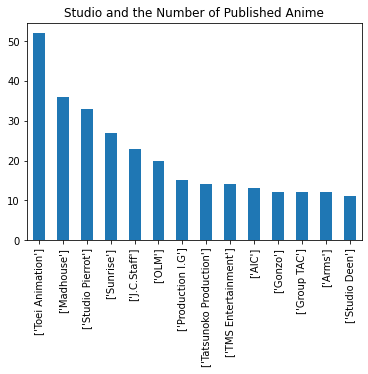

In [64]:
#MAKE MEDIAN STUDIO POPULARITY
#MAKE CHART

import matplotlib.pyplot as plt 

plt.title('Studio and the Number of Published Anime')
studio_appearances = df.Studios.value_counts()
studio_appearances[studio_appearances > 10].plot(kind = 'bar')

charts

<AxesSubplot:title={'center':'Genres and the Number of Published Anime'}>

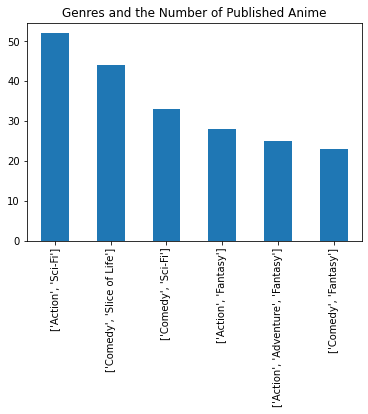

In [65]:

#cut genres
#median genre popularity
#make chart of genre vs populrity


plt.title('Genres and the Number of Published Anime')
genre_appearances = df.Genres.value_counts()
genre_appearances[genre_appearances > 20].plot(kind = 'bar')

find if studio made sequal

In [66]:
#check if sequal.

<AxesSubplot:title={'center':'How many times each popularity appears modul 5000'}, xlabel='Popularity'>

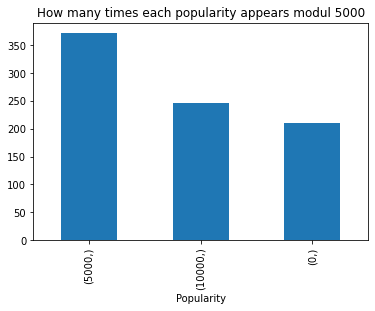

In [67]:
plt.title('How many times each popularity appears modul 5000')
df_popularity = df[['Popularity']].apply(lambda x: (x-(x%5000)))
df_popularity

df_popularity_count = df_popularity.value_counts()
df_popularity_count.plot(kind = 'bar')


<AxesSubplot:title={'center':'Source and the Number of Published Anime'}>

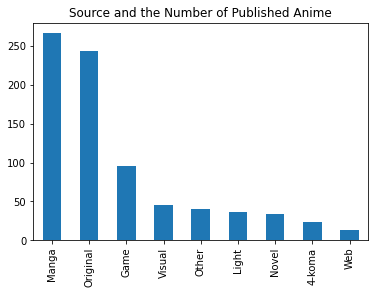

In [68]:
plt.title('Source and the Number of Published Anime')
source_appearances = df['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')

In [69]:
df_highpop = df[df['Popularity']>10000]
df_highpop

,Title,MAL Id,Type,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score
18703,Wo Jiao Bai Xiaofei,33357,ONA,11 min. per ep.,['Haoliners Animation League'],Web,"['Action', 'Comedy', 'Horror']",N\A,PG-13 - Teens 13 or older,10627,6.15
30234,Da Yu Hai Tang,39264,ONA,7 min.,['B&T'],Original,"['Adventure', 'Drama', 'Romance', 'Supernatural']",N\A,G - All Ages,11070,6.07
10926,"Umi no Yami, Tsuki no Kage",4484,OVA,30 min. per ep.,['Magic Bus'],Manga,"['Drama', 'Horror', 'Romance']",N\A,R - 17+ (violence & profanity),10197,5.84
41967,Majokko Club Yoningumi: A Kuukan kara no Alien X,2080,OVA,27 min.,['Studio Pierrot'],Original,"['Action', 'Comedy', 'Sci-Fi']",N\A,PG-13 - Teens 13 or older,11149,5.71
36146,Bouken Yuuki Pluster World,3637,TV,24 min. per ep.,"['Actas', ""Brain's Base""]",Original,"['Action', 'Adventure', 'Sci-Fi']",N\A,G - All Ages,11705,6.08
...,...,...,...,...,...,...,...,...,...,...,...
13119,Tales of the Rays Gekijou,36955,ONA,3 min. per ep.,['Bandai Namco Pictures'],Game,"['Comedy', 'Fantasy']",N\A,PG-13 - Teens 13 or older,10628,6.19
11307,Soliton no Akuma,10718,Movie,1 hr. 30 min.,['Triangle Staff'],Novel,"['Drama', 'Sci-Fi']",N\A,R - 17+ (violence & profanity),11656,5.96
37396,Gall Force: The Revolution,2066,OVA,30 min. per ep.,['AIC'],Original,"['Action', 'Adventure', 'Sci-Fi']","['Mecha', 'Military', 'Space']",R+ - Mild Nudity,10173,5.92
4146,Yuukan Club,3778,OVA,35 min. per ep.,['Madhouse'],Manga,"['Comedy', 'Mystery']",N\A,PG-13 - Teens 13 or older,11628,5.82


<AxesSubplot:title={'center':'Source and the Number of Published Anime for High Popularity Anime'}>

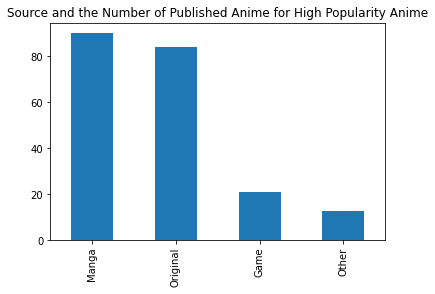

In [70]:
plt.title('Source and the Number of Published Anime for High Popularity Anime')
source_appearances = df_highpop['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')